In [1]:
# Importing necessary libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

## Data preprocessing

###Read data

In [2]:
# Load data
df = pd.read_csv('/BA_trainmodel/data/CTLT.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,30.860001,31.260000,30.240000,30.910000,30.910000,1201700
1,2019-01-03,30.660000,30.660000,29.290001,29.840000,29.840000,1149900
2,2019-01-04,30.049999,31.360001,29.940001,31.080000,31.080000,3530400
3,2019-01-07,31.020000,32.180000,30.850000,32.000000,32.000000,1063400
4,2019-01-08,32.340000,33.060001,32.150002,32.790001,32.790001,1391000
...,...,...,...,...,...,...,...
1114,2023-06-06,37.910000,39.049999,37.580002,38.820000,38.820000,2261700
1115,2023-06-07,39.160000,40.029999,38.250000,39.959999,39.959999,4382500
1116,2023-06-08,39.700001,39.840000,36.750000,39.000000,39.000000,9705500
1117,2023-06-09,39.250000,40.110001,38.480000,38.810001,38.810001,4493800


###Reset index

In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Select the Close column as the dependent variable
df_Close = df[['Close']]
#df_Close = df_Close.dropna() # Drop missing values
df_Close = df_Close.reset_index(drop=True) # Reset the index
df_Close.head(20)

,Close
0,30.910000
1,29.840000
2,31.080000
3,32.000000
4,32.790001
5,33.380001
6,33.880001
7,33.750000
8,33.590000
9,34.070000


###Data normalization

In [5]:
# Scaling the data
scaler=MinMaxScaler(feature_range=(0,1))
data_scaled=scaler.fit_transform(df_Close)
data_scaled

array([[0.00951027],
       [0.        ],
       [0.01102124],
       ...,
       [0.08141498],
       [0.07972625],
       [0.11501198]])

###Data splitting

In [6]:
# Split the data into training, validation and test dataset in a ratio of 6:2:2
train_size = int(0.6 * len(data_scaled))
val_size = int(0.2 * len(data_scaled))
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[: train_size]
val_data = data_scaled[train_size : train_size + val_size]
test_data = data_scaled[train_size + val_size :]

In [7]:
def create_dataset(dataset, time_step, prev_data=None):
    dataX, dataY = [], []
    start_index = 0
    
    # If previous data is available
    if prev_data is not None:
        start_index = max(0, time_step - len(prev_data))
        dataset = np.concatenate((prev_data, dataset))
        
    for i in range(start_index, len(dataset)-time_step):
        dataX.append(dataset[i:(i+time_step), 0])
        dataY.append(dataset[i + time_step, 0])
        
    return np.array(dataX), np.array(dataY)


##Model training and testing

###Define the parameter GBT

In [8]:
# Grid of time_steps to try
time_step_grid = [30, 50, 60, 70, 100]

In [9]:
# Define the parameter grid
param_grid = {
    'n_estimators': [200, 300, 500],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3, 4]
}


In [10]:
# Defining the GBT Model
gbt = GradientBoostingRegressor(n_iter_no_change=5, tol=0.01, random_state=0)

In [11]:
random_search = RandomizedSearchCV(estimator=gbt, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=0, n_jobs=-1)

In [12]:
best_val_MAPE = float("inf")
best_params = None
best_time_step = None
best_gbt = None
best_y_pred_val_inv = None
best_y_val_inv = None

In [13]:
for time_step in time_step_grid:
    # Reshape into X=t,t+1,t+2..t+time_step_grid[i] and Y=t+time_step_grid[i]
    X_train, y_train = create_dataset(train_data, time_step)

    # Prepare previous data for validation set
    last_train_data = train_data[-time_step:]

    # Create validation set
    X_val, y_val = create_dataset(val_data, time_step, last_train_data)

    # Fitting the random search model
    random_search.fit(X_train, y_train)

    # Create a new model with these parameters
    candidate_gbt = GradientBoostingRegressor(**random_search.best_params_, random_state=0)

    # Fit the model with the training data
    candidate_gbt.fit(X_train, y_train)

    # Predicting on validation data
    y_pred_val = candidate_gbt.predict(X_val)
    y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))
    y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))

    valid_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)

    # Check if this model is better than the previous ones
    if valid_MAPE < best_val_MAPE:
        best_params = random_search.best_params_
        best_val_MAPE = valid_MAPE
        best_time_step = time_step
        best_gbt = candidate_gbt
        best_y_pred_val_inv = y_pred_val_inv
        best_y_val_inv = y_val_inv

    # Print the MAPE for this time_step
    print(f"Time step: {time_step}, Validation MAPE: {valid_MAPE}")

print("Best time step: ", best_time_step)
print("Best parameters: ", best_params)
print("Validation MAPE with best time step and parameters: ", best_val_MAPE)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 30, Validation MAPE: 0.0300348978430625
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 50, Validation MAPE: 0.03076696871086811
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 60, Validation MAPE: 0.03202321642953089
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 70, Validation MAPE: 0.04287935129284492
Fitting 10 folds for each of 100 candidates, totalling 1000 fits
Time step: 100, Validation MAPE: 0.030422207160633333
Best time step:  30
Best parameters:  {'n_estimators': 300, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.15}
Validation MAPE with best time step and parameters:  0.0300348978430625


##Train with best time step and best parameters

In [14]:
# Once we have the best params and time step, we recreate all datasets and fit the model again
X_train, y_train = create_dataset(train_data, best_time_step)

# Prepare previous data for val set
last_ppoints_train = train_data[-best_time_step:]
X_val, y_val = create_dataset(val_data, best_time_step,last_ppoints_train)


# Prepare previous data for test set
last_points_val = val_data[-best_time_step:]
X_test, y_test = create_dataset(test_data, best_time_step, last_points_val)

In [15]:
# Fit the model with the combined training data
best_gbt.fit(X_train,y_train)

GradientBoostingRegressor(learning_rate=0.15, min_samples_split=4,
                          n_estimators=300, random_state=0)

In [16]:
# Now use this to make predictions
y_pred_val =best_gbt.predict(X_val)
y_pred_test=best_gbt.predict(X_test)

##Testing process

In [17]:
# And scale the predictions back to the original range
y_val_inv = scaler.inverse_transform(y_val.reshape(-1,1))
y_pred_val_inv = scaler.inverse_transform(y_pred_val.reshape(-1,1))

y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
y_pred_test_inv = scaler.inverse_transform(y_pred_test.reshape(-1,1))


In [18]:
val_MAPE = mean_absolute_percentage_error(y_val_inv, y_pred_val_inv)
val_RMSE = mean_squared_error(y_val_inv, y_pred_val_inv, squared=False)
val_MSLE = mean_squared_log_error(y_val_inv, y_pred_val_inv)
print('MAPE on the data val:', val_MAPE)
print('RMSE on the data val', val_RMSE)
print('MSLE on the data val', val_MSLE)

MAPE on the data val: 0.0300348978430625
RMSE on the data val 5.001858826462516
MSLE on the data val 0.0016482802434749874


In [19]:
test_MAPE = mean_absolute_percentage_error(y_test_inv, y_pred_test_inv)
test_RMSE = mean_squared_error(y_test_inv, y_pred_test_inv, squared=False)
test_MSLE = mean_squared_log_error(y_test_inv, y_pred_test_inv)
print('MAPE on the data test:', test_MAPE)
print('RMSE on the data test', test_RMSE)
print('MSLE on the data test', test_MSLE)

MAPE on the data test: 0.06033645014182621
RMSE on the data test 4.3501912550404445
MSLE on the data test 0.007010961426681263


##Predicting the next 30 days

In [20]:
# Predict the closing prices for the next 30 days
x_input=test_data[-best_time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=best_time_step
i=0
while(i<30):
    if(len(temp_input)>n_steps):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        next_date = best_gbt.predict(x_input)
        print("{} day output {}".format(i,next_date))
        temp_input.extend(next_date.tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(next_date.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps))
        next_date = best_gbt.predict(x_input)
        print(next_date[0])
        temp_input.extend(next_date.tolist())
        print(len(temp_input))
        lst_output.extend(next_date.tolist())
        i=i+1


0.10506242890282932
31
1 day input [0.16780731 0.16887387 0.17234023 0.15918584 0.0499511  0.04621812
 0.03333037 0.03866322 0.02684207 0.02977512 0.01795397 0.02026486
 0.02044262 0.06514974 0.0681717  0.07368234 0.06754954 0.06257222
 0.06470535 0.05848367 0.06568305 0.06363878 0.07003822 0.07074925
 0.07981512 0.08994755 0.08141498 0.07972625 0.11501198 0.10506243]
1 day output [0.12651304]
2 day input [0.16887387 0.17234023 0.15918584 0.0499511  0.04621812 0.03333037
 0.03866322 0.02684207 0.02977512 0.01795397 0.02026486 0.02044262
 0.06514974 0.0681717  0.07368234 0.06754954 0.06257222 0.06470535
 0.05848367 0.06568305 0.06363878 0.07003822 0.07074925 0.07981512
 0.08994755 0.08141498 0.07972625 0.11501198 0.10506243 0.12651304]
2 day output [0.12934724]
3 day input [0.17234023 0.15918584 0.0499511  0.04621812 0.03333037 0.03866322
 0.02684207 0.02977512 0.01795397 0.02026486 0.02044262 0.06514974
 0.0681717  0.07368234 0.06754954 0.06257222 0.06470535 0.05848367
 0.06568305 0.06

In [21]:
lst_output = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))
print('Predicted closing prices for the next 30 days:')
print(lst_output)

Predicted closing prices for the next 30 days:
[[41.66057451]
 [44.07398323]
 [44.39285859]
 [46.10443789]
 [46.4301156 ]
 [47.44899596]
 [47.50517022]
 [48.04770922]
 [49.52503778]
 [50.04527985]
 [51.125004  ]
 [51.85100313]
 [51.93658647]
 [53.21114729]
 [54.19993811]
 [54.95827519]
 [55.58313176]
 [57.3271061 ]
 [58.42394335]
 [59.74501076]
 [62.40147654]
 [62.80187384]
 [63.38618171]
 [65.26305509]
 [69.41061865]
 [70.16037264]
 [70.57920351]
 [70.32670043]
 [70.88467904]
 [71.48237863]]


##Preparing the forecast date index

##Visualization

In [22]:
# Convert integer indexes back to datetime
train_data_index = df.index[:train_size]
val_data_index = df.index[train_size:train_size+ val_size]
test_data_index = df.index[train_size + val_size:]

# Assuming predict_data_index is the 30 days following the last date in the validation data
predict_data_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30)

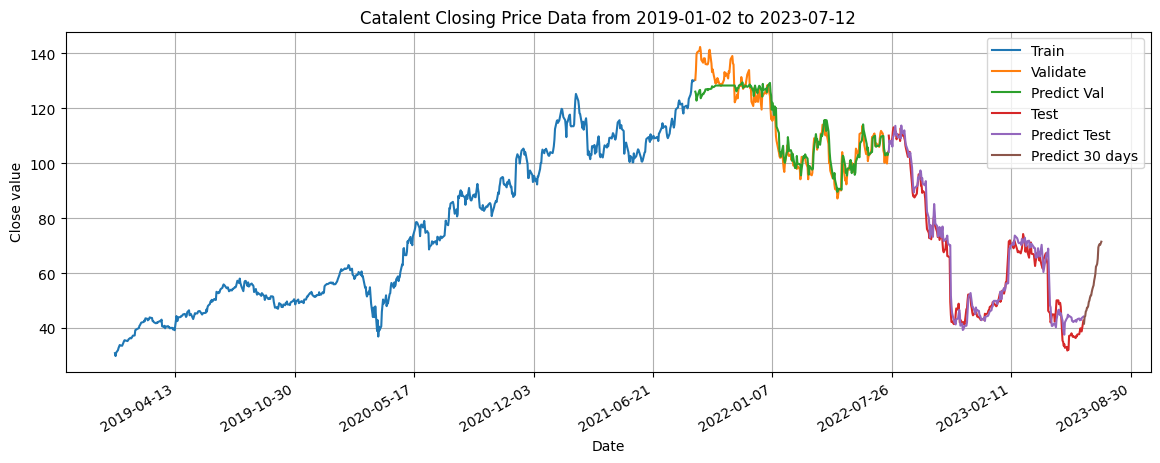

In [23]:
# Plotting Data
plt.figure(figsize=(14, 5))
plt.plot(train_data_index, scaler.inverse_transform(train_data), label='Train')
plt.plot(val_data_index, scaler.inverse_transform(val_data), label='Validate')
plt.plot(val_data_index, y_pred_val_inv, label='Predict Val')
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')
plt.plot(test_data_index, y_pred_test_inv, label='Predict Test')

plt.plot(predict_data_index, lst_output, label='Predict 30 days')

plt.grid()
plt.title(f"Catalent Closing Price Data from {train_data_index[0].strftime('%Y-%m-%d')} to {predict_data_index[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Date")
plt.ylabel("Close value")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=200)) # Select markers spaced 200 days apart
plt.gcf().autofmt_xdate() #  Rotate date labels for better readability
plt.legend()
plt.savefig('../Image/GBT_622_CTLT.png')
plt.show()